In [1]:
import os
import sys

import numpy  as np
import tables as tb
import pandas as pd
import matplotlib
import math

#the line below makes the plot as a pop-up, that can be saved
#matplotlib.use('TkAgg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import matplotlib.cm as cm
from matplotlib.colors import Normalize

from scipy.stats import norm
from scipy.stats import exponnorm
from scipy.stats import skewnorm


from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.core.exceptions import NoHits

In [2]:
import functions.histo_functions as myhf
import functions.efficiency_functions as myef
import functions.recovstrue as myrvt

In [3]:
#Dimensions for the NEXT100 detector
veto_N100 = 20 # mm
rmax_N100 = 492 - veto_N100
#rmax_N100 = 200
zmin_N100 = veto_N100
zmax_N100 = 1205 - veto_N100

In [4]:
filepath = '/Users/halmamol/NEXT/files/NEXT100/beershebaDS/'
max0nubbf = 999
maxselectron = 999
blobR = 21

## Opening TRACK Files - 0nubb

In [5]:
#0nubb files
track_list_0nubb = []

filepath_0nubb_tracks = filepath+f'0nubb/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_tracks+f'next100.0nubb.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks = pd.read_hdf(filename_0nubb, 'Tracks')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    track_list_0nubb.append(readfile_tracks)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_0nubb = pd.concat([dt for dt in track_list_0nubb]) 
tracks_0nubb.columns  

#these are all the elements inside the file:

File /Users/halmamol/NEXT/files/NEXT100/beershebaDS/0nubb/tracks/21mm/next100.0nubb.600.skel_tracks.R21mm.h5 not good


Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

In [6]:
#same for selectron files
track_list_selectron = []
filepath_selectron_tracks = filepath+f'/e-_roi/tracks/{blobR}mm/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,maxselectron):
    
    filename_selectron = filepath_selectron_tracks+f'next100.e-_roi.{nfile}.skel_tracks.R{blobR}mm.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_tracks_selectron = pd.read_hdf(filename_selectron, 'Tracks')
    except:
        print('File {} not good'.format(filename_selectron))
        continue
        
    track_list_selectron.append(readfile_tracks_selectron)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

tracks_selectron = pd.concat([dt for dt in track_list_selectron]) 
tracks_selectron.columns  

#these are all the elements inside the file:

Index(['event', 'trackID', 'energy', 'length', 'numb_of_voxels',
       'numb_of_hits', 'numb_of_tracks', 'x_min', 'y_min', 'z_min', 'x_max',
       'y_max', 'z_max', 'r_max', 'x_ave', 'y_ave', 'z_ave', 'extreme1_x',
       'extreme1_y', 'extreme1_z', 'extreme2_x', 'extreme2_y', 'extreme2_z',
       'blob1_x', 'blob1_y', 'blob1_z', 'blob2_x', 'blob2_y', 'blob2_z',
       'eblob1', 'eblob2', 'ovlp_blob_energy', 'vox_size_x', 'vox_size_y',
       'vox_size_z'],
      dtype='object')

## Checking DECO tracks

#0nubb files
deco_list_0nubb = []

filepath_0nubb_deco = filepath+f'0nubb/hits/'

#loop over all the files, to read 'Tracks' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb = filepath_0nubb_deco+f'next100.0nubb.{nfile}.deconv.h5'
    #the following lines are added because some of the files aren't there (I had to check Paola's notebook)
    try:
        readfile_deco = pd.read_hdf(filename_0nubb, 'DECO/Events')
    except:
        print('File {} not good'.format(filename_0nubb))
        continue
        
    deco_list_0nubb.append(readfile_deco)
    

#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

deco_0nubb = pd.concat([dt for dt in deco_list_0nubb]) 
deco_0nubb.columns  

base_vsize = 5 #mm
this_evt_df = deco_0nubb[deco_0nubb.event == 100]
the_hits = []

xs = this_evt_df.X
ys = this_evt_df.Y
zs = this_evt_df.Z
es = this_evt_df.E

for x, y, z, e in zip(xs, ys, zs, es):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([base_vsize, base_vsize, base_vsize]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = [v.E for v in voxels]

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
cmap = cm.viridis
norm = Normalize(vmin=0, vmax=max(e))

colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))

# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels
ax.voxels(a,b,c, VOXELS, facecolors=colors , edgecolor='k',alpha=0.8)

ax.set_xlabel('x (mm)')#,fontsize=16)
ax.set_ylabel('y (mm)')#,fontsize=16)
ax.set_zlabel('z (mm)')#,fontsize=16)

ax.set_xlim([-40, 80])
ax.set_ylim([-450, -330])
ax.set_zlim([950, 1020])
#ax.view_init(30, 210)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cb = fig.colorbar(sm)
cb.set_label('Energy (keV)')

plt.show()

## Checking cuts

interested in selecting the events in/with:
- **Fiducial**: fiducial cut around the detector volume, of 2cm from the border
- **1Track**: in this case, considers the track with highest deposition
- **NoOverlap**: defined blobs in one trace should not overlap
- **ROI**: energy cut in the region of interest, between [2.445,2475]MeV

In [7]:
#Checking total amount of events, prior any selection
nevents_0nubb_total = tracks_0nubb.event.nunique()
Enevents_0nubb_total = np.sqrt(nevents_0nubb_total)
print(f'Initial amount of events for 0nubb: {nevents_0nubb_total} +- {Enevents_0nubb_total}')

nevents_selectron_total = tracks_selectron.event.nunique()
Enevents_selectron_total = np.sqrt(nevents_selectron_total)
print(f'Initial amount of events for selectrons: {nevents_selectron_total} +- {Enevents_selectron_total}')

Initial amount of events for 0nubb: 9791 +- 98.94948206029176
Initial amount of events for selectrons: 9766 +- 98.82307422864359


### 1 - FIDUCIAL CUT

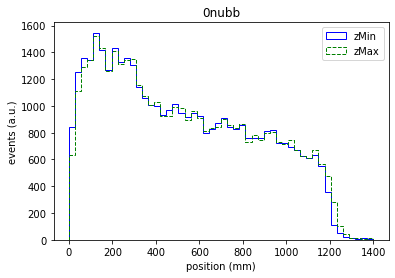

In [8]:
track_0nubb_zmin = tracks_0nubb.z_min
track_0nubb_zmax = tracks_0nubb.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

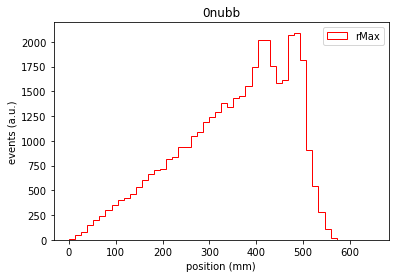

In [9]:
track_0nubb_rmax = tracks_0nubb.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

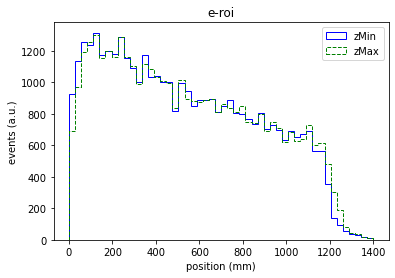

In [10]:
track_selectron_zmin = tracks_selectron.z_min
track_selectron_zmax = tracks_selectron.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

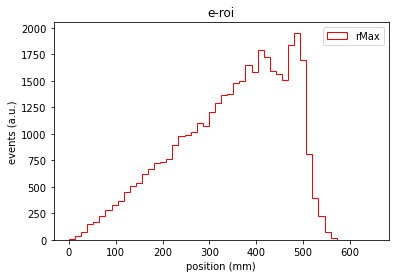

In [11]:
track_selectron_rmax = tracks_selectron.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

In [12]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- Rmax = {np.amax(track_0nubb_rmax)}')
print(f'- Zmin = {np.amax(track_0nubb_zmin)}')
print(f'- Zmax = {np.amax(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.amax(track_selectron_rmax)}')
print(f'- Zmin = {np.amax(track_selectron_zmin)}')
print(f'- Zmax = {np.amax(track_selectron_zmax)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- Rmax = {np.average(track_0nubb_rmax)}')
print(f'- Zmin = {np.average(track_0nubb_zmin)}')
print(f'- Zmax = {np.average(track_0nubb_zmax)}')
print(f'e-roi')
print(f'- Rmax = {np.average(track_selectron_rmax)}')
print(f'- Zmin = {np.average(track_selectron_zmin)}')
print(f'- Zmax = {np.average(track_selectron_zmax)}')

MAX VALUE
0nubb
- Rmax = 578.5054018762487
- Zmin = 1455.0408750000001
- Zmax = 1463.791125
e-roi
- Rmax = 574.5768007847166
- Zmin = 1454.1785
- Zmax = 1463.777625
AVG VALUE
0nubb
- Rmax = 351.7306698027909
- Zmin = 518.2073825388853
- Zmax = 530.4413493560528
e-roi
- Rmax = 347.39148763628464
- Zmin = 530.638262605807
- Zmax = 545.7328724653246


In [13]:
npz_file = '/Users/halmamol/NEXT/NBarrays/tracklimits_DETSIM'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax=track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmax, track_selectron_rmax=track_selectron_rmax)


In [14]:
#For the evaluation of the events out of fiducial limits it's necessary to do several steps

#First, check a list of events where at least 1 trace is out of the limits:

nonfiducial_list_0nubb = tracks_0nubb[~((tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_0nubb = tracks_0nubb[(tracks_0nubb.r_max < rmax_N100) & 
                                     (tracks_0nubb.z_min > zmin_N100) & 
                                     (tracks_0nubb.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_0nubb    = ~fiducial_tracks_0nubb.event.isin(nonfiducial_list_0nubb) 

# And finally I select the events with an asigned True from the previous line 
tracks_0nubb_fiducial = fiducial_tracks_0nubb[evt_fid_sel_0nubb]

In [15]:
#Now I do the same for single electron

nonfiducial_list_selectron = tracks_selectron[~((tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100))].event.unique()

#Then I apply the selection into the matrix of elements
fiducial_tracks_selectron = tracks_selectron[(tracks_selectron.r_max < rmax_N100) & 
                                     (tracks_selectron.z_min > zmin_N100) & 
                                     (tracks_selectron.z_max < zmax_N100)]

# I get a list of true elements if event ID is not in the above list 'nonfiducial_list'
evt_fid_sel_selectron    = ~fiducial_tracks_selectron.event.isin(nonfiducial_list_selectron) 

# And finally I select the events with an asigned True from the previous line 
tracks_selectron_fiducial = fiducial_tracks_selectron[evt_fid_sel_selectron]

In [16]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_fiducial = tracks_0nubb_fiducial.event.nunique()
Enevents_0nubb_fiducial = np.sqrt(nevents_0nubb_fiducial)
nevents_selectron_fiducial = tracks_selectron_fiducial.event.nunique()
Enevents_selectron_fiducial = np.sqrt(nevents_selectron_fiducial)

ratio_fiducial_0nubb = 100*nevents_0nubb_fiducial/nevents_0nubb_total
Eratio_fiducial_0nubb = myef.ratio_error(ratio_fiducial_0nubb, nevents_0nubb_fiducial, nevents_0nubb_total, 
                                             Enevents_0nubb_fiducial, Enevents_0nubb_total)

ratio_fiducial_selectron = 100*nevents_selectron_fiducial/nevents_selectron_total
Eratio_fiducial_selectron = myef.ratio_error(ratio_fiducial_selectron, nevents_selectron_fiducial, nevents_selectron_total, 
                                             Enevents_selectron_fiducial, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
--------!--------------!----------------!----------------


## 2 - Number of tracks

In [17]:
#Therefore, I'm going to take the 1st 'trackID'
tracks_0nubb_1track = tracks_0nubb[tracks_0nubb.trackID == 0]
tracks_0nubb_1trackfid = tracks_0nubb_fiducial[tracks_0nubb_fiducial.trackID == 0]

tracks_selectron_1track = tracks_selectron[tracks_selectron.trackID == 0]
tracks_selectron_1trackfid = tracks_selectron_fiducial[tracks_selectron_fiducial.trackID == 0]

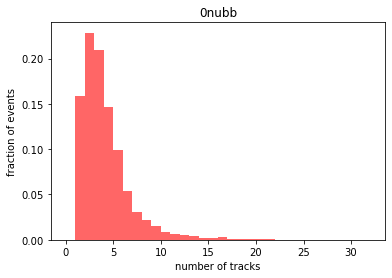

In [18]:
#Check the number of tracks with numb_of_tracks
ntracks_0nubb = tracks_0nubb_1trackfid.numb_of_tracks
maxtracks_0nubb = np.amax(ntracks_0nubb)

plt.hist(ntracks_0nubb, bins = maxtracks_0nubb, range = (0, maxtracks_0nubb),density=True, alpha=0.6, color='r')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('0nubb')
plt.show()

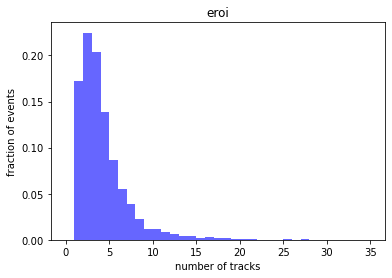

In [19]:
#Check the number of tracks with numb_of_tracks
ntracks_eroi = tracks_selectron_1trackfid.numb_of_tracks
maxtracks_eroi = np.amax(ntracks_eroi)

plt.hist(ntracks_eroi, bins = maxtracks_eroi, range = (0, maxtracks_eroi), density=True, alpha=0.6, color='b')
plt.xlabel('number of tracks')
plt.ylabel('fraction of events')
plt.title('eroi')
plt.show()

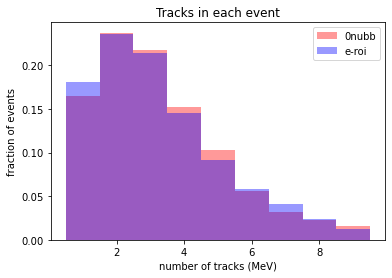

In [20]:
plt.hist(ntracks_0nubb, bins = 9, range = (0.5, 9.5),density=True, alpha=0.4, color='r', label = '0nubb')
plt.hist(ntracks_eroi, bins = 9, range = (0.5, 9.5), density=True, alpha=0.4, color='b',label = 'e-roi')

plt.xlabel('number of tracks (MeV)')
plt.ylabel('fraction of events')
plt.title('Tracks in each event')
plt.legend(loc=1);
plt.show()

In [21]:
print(f'MAX VALUE')
print(f'0nubb')
print(f'- #tracks = {np.amax(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.amax(ntracks_eroi)}')
print(f'AVG VALUE')
print(f'0nubb')
print(f'- #tracks = {np.average(ntracks_0nubb)}')
print(f'e-roi')
print(f'- #tracks = {np.average(ntracks_eroi)}')
print(f'1-track events')
print(f'0nubb')
print(f'- 1 track = {100*(tracks_0nubb[tracks_0nubb.numb_of_tracks == 1].event.nunique())/(tracks_0nubb.event.nunique())}')
print(f'e-roi')
print(f'- 1 track = {100*(tracks_selectron[tracks_selectron.numb_of_tracks == 1].event.nunique())/(tracks_selectron.event.nunique())}')


MAX VALUE
0nubb
- #tracks = 32
e-roi
- #tracks = 35
AVG VALUE
0nubb
- #tracks = 3.6527972572853358
e-roi
- #tracks = 3.7297165991902834
1-track events
0nubb
- 1 track = 13.144724747216832
e-roi
- 1 track = 16.588163014540243


In [22]:
tracks_0nubb_track_evt = tracks_0nubb_1track[tracks_0nubb_1track.event == 100]
tracks_0nubb_track_evt.numb_of_tracks

0    2
Name: numb_of_tracks, dtype: int64

In [23]:
tracks_0nubb_1track_cut = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.numb_of_tracks == 1]
frac_1track_0nubb = 100*tracks_0nubb_1track_cut.event.nunique()/nevents_0nubb_fiducial

Efrac_1track_0nubb = myef.ratio_error(frac_1track_0nubb, tracks_0nubb_1track_cut.event.nunique(), nevents_0nubb_fiducial, 
                                             np.sqrt(tracks_0nubb_1track_cut.event.nunique()), np.sqrt(nevents_0nubb_fiducial))
print(f'Amount of events with 1 track 0nubb = {frac_1track_0nubb} +- {Efrac_1track_0nubb}')

Amount of events with 1 track 0nubb = 15.848527349228611 +- 0.5349013523680529


In [24]:
tracks_selectron_1track_cut = tracks_selectron_1trackfid[tracks_selectron_1trackfid.numb_of_tracks == 1]
frac_1track_selectron = 100*tracks_selectron_1track_cut.event.nunique()/nevents_selectron_fiducial
Efrac_1track_selectron = myef.ratio_error(frac_1track_selectron, tracks_selectron_1track_cut.event.nunique(), nevents_selectron_fiducial, 
                                             np.sqrt(tracks_selectron_1track_cut.event.nunique()), np.sqrt(nevents_selectron_fiducial))
print(f'Amount of events with 1 track eroi = {frac_1track_selectron} +- {Efrac_1track_selectron}')

Amount of events with 1 track eroi = 17.19838056680162 +- 0.571328780150671


In [25]:
#Checking total amount of events, after fiducial selection

nevents_0nubb_1track = tracks_0nubb_1track.event.nunique()
Enevents_0nubb_1track = np.sqrt(nevents_0nubb_1track)
nevents_0nubb_1trackfid = tracks_0nubb_1trackfid.event.nunique()
Enevents_0nubb_1trackfid = np.sqrt(nevents_0nubb_1trackfid)

nevents_selectron_1track = tracks_selectron_1track.event.nunique()
Enevents_selectron_1track = np.sqrt(nevents_selectron_1track)
nevents_selectron_1trackfid = tracks_selectron_1trackfid.event.nunique()
Enevents_selectron_1trackfid = np.sqrt(nevents_selectron_1trackfid)

ratio_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_fiducial
Eratio_1trackfid_0nubb = myef.ratio_error(ratio_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_fiducial, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_fiducial)

eff_1trackfid_0nubb = 100*nevents_0nubb_1trackfid/nevents_0nubb_total
Eeff_1trackfid_0nubb = myef.ratio_error(eff_1trackfid_0nubb, nevents_0nubb_1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_1trackfid, Enevents_0nubb_total)

ratio_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_fiducial
Eratio_1trackfid_selectron = myef.ratio_error(ratio_1trackfid_0nubb, nevents_selectron_1trackfid, nevents_selectron_fiducial, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_fiducial)

eff_1trackfid_selectron = 100*nevents_selectron_1trackfid/nevents_selectron_total
Eeff_1trackfid_selectron = myef.ratio_error(eff_1trackfid_selectron, nevents_selectron_1trackfid, nevents_selectron_total, 
                                             Enevents_selectron_1trackfid, Enevents_selectron_total)

print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')

print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')


--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
--------!--------------!----------------!----------------


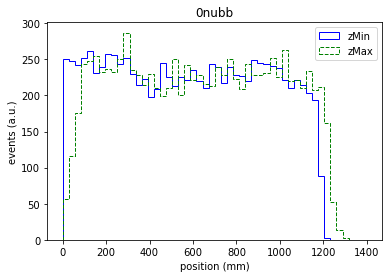

In [26]:
track_0nubb_zmin = tracks_0nubb_1track.z_min
track_0nubb_zmax = tracks_0nubb_1track.z_max

plt.hist(track_0nubb_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_0nubb_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

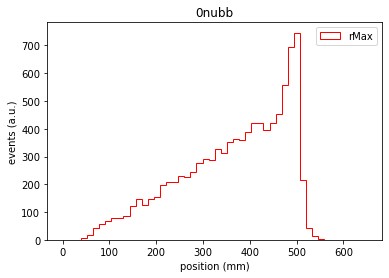

In [27]:
track_0nubb_rmax = tracks_0nubb_1track.r_max

plt.hist(track_0nubb_rmax, bins = 50, range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

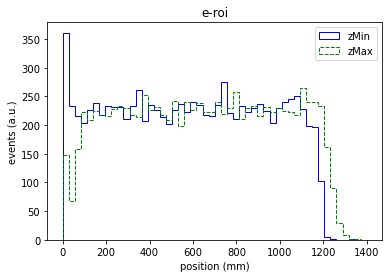

In [28]:
track_selectron_zmin = tracks_selectron_1track.z_min
track_selectron_zmax = tracks_selectron_1track.z_max

plt.hist(track_selectron_zmin, bins = 50, range = (0, 1400),  color='blue', histtype='step', label = 'zMin')
plt.hist(track_selectron_zmax, bins = 50, range = (0, 1400),  color='green', histtype='step', label = 'zMax', linestyle='dashed')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

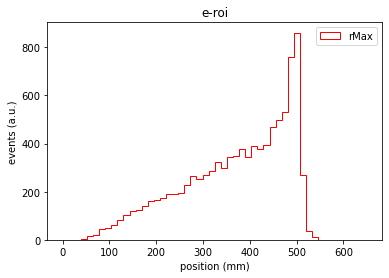

In [29]:
track_selectron_rmax = tracks_selectron_1track.r_max

plt.hist(track_selectron_rmax, bins = 50,  range = (0, 650),  color='red', histtype='step', label = 'rMax')

plt.xlabel('position (mm)')
plt.ylabel('events (a.u.)')
plt.title('e-roi')
plt.legend(loc=1);
plt.show()

## 3 - No overlap

In [30]:
#Getting ovlp variable of the tracks, and selecting events with no ovlp

tracks_0nubb_ovlp = tracks_0nubb[tracks_0nubb.ovlp_blob_energy == 0.]
tracks_0nubb_ovlp1trackfid = tracks_0nubb_1trackfid[tracks_0nubb_1trackfid.ovlp_blob_energy == 0.]

tracks_selectron_ovlp = tracks_selectron[tracks_selectron.ovlp_blob_energy == 0.]
tracks_selectron_ovlp1trackfid = tracks_selectron_1trackfid[tracks_selectron_1trackfid.ovlp_blob_energy == 0.]

In [31]:
#Checking total amount of events, after overlap selection

nevents_0nubb_ovlp = tracks_0nubb_ovlp.event.nunique()
Enevents_0nubb_ovlp = np.sqrt(nevents_0nubb_ovlp)
nevents_0nubb_ovlp1trackfid = tracks_0nubb_ovlp1trackfid.event.nunique()
Enevents_0nubb_ovlp1trackfid = np.sqrt(nevents_0nubb_ovlp1trackfid)

nevents_selectron_ovlp = tracks_selectron_ovlp.event.nunique()
Enevents_selectron_ovlp = np.sqrt(nevents_selectron_ovlp)
nevents_selectron_ovlp1trackfid = tracks_selectron_ovlp1trackfid.event.nunique()
Enevents_selectron_ovlp1trackfid = np.sqrt(nevents_selectron_ovlp1trackfid)

ratio_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_1trackfid
Eratio_ovlp1trackfid_0nubb = myef.ratio_error(ratio_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_1trackfid, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_1trackfid)

eff_ovlp1trackfid_0nubb = 100*nevents_0nubb_ovlp1trackfid/nevents_0nubb_total
Eeff_ovlp1trackfid_0nubb = myef.ratio_error(eff_ovlp1trackfid_0nubb, nevents_0nubb_ovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ovlp1trackfid, Enevents_0nubb_total)

ratio_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_1trackfid
Eratio_ovlp1trackfid_selectron = myef.ratio_error(ratio_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_1trackfid, 
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_1trackfid)

eff_ovlp1trackfid_selectron = 100*nevents_selectron_ovlp1trackfid/nevents_selectron_total
Eeff_ovlp1trackfid_selectron = myef.ratio_error(eff_ovlp1trackfid_selectron, nevents_selectron_ovlp1trackfid, nevents_selectron_total,
                                             Enevents_selectron_ovlp1trackfid, Enevents_selectron_total)
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')



--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
OVLP       5720        89.13822658563191+- 1.6208977948747234%   58.42099887651925 +- 0.9722486246586135%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
OVLP       5963        96.56680161943319+- 1.7532769705721076%   61.05877534302683 +- 1.0034780586956173%
--------!--------------!----------------!----------------


## 4 - ROI events

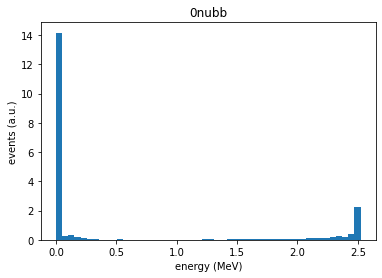

In [32]:
#Getting energy of the tracks
energy_0nubb = tracks_0nubb.energy

plt.hist(energy_0nubb, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

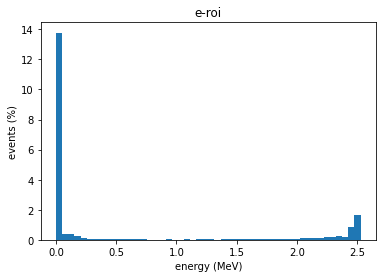

In [33]:
#Getting energy of the tracks
energy_selectron = tracks_selectron.energy

plt.hist(energy_selectron, bins = 50, density = True)
plt.xlabel('energy (MeV)')
plt.ylabel('events (%)')
plt.title('e-roi')
plt.show()

In [34]:
#Check limits of the Energy ROI 

emin = 2.40
emax = 2.54

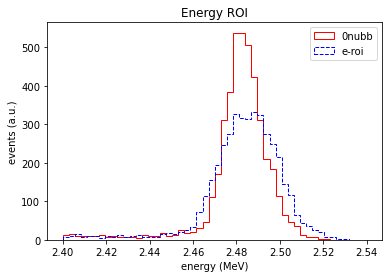

In [35]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

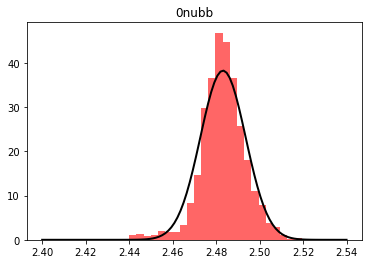

Fit results: mu = 2.4831767631781174,  std = 0.010410511627992168 


2.4311242050381567

In [36]:
tracks_0nubb_zoom = tracks_0nubb_ROIovlp1trackfid[(tracks_0nubb_ROIovlp1trackfid.energy >= 2.44)]
energy_0nubb_zoom = tracks_0nubb_zoom.energy

mu, std = norm.fit(energy_0nubb_zoom)

# Plot the histogram.
plt.hist(energy_0nubb_zoom, bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(emin, emax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')
mu-5*std

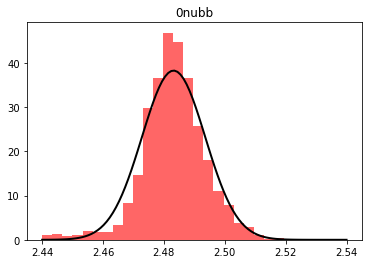

Fit results: mu = 2.483183435638094,  std = 0.010410512452849748 


In [37]:
ae, loce, scalee = skewnorm.fit(energy_0nubb_zoom)

# Plot the histogram.
plt.hist(energy_0nubb_zoom, bins=25, density=True, alpha=0.6, color='r')

# Plot the PDF.
x = np.linspace(2.44, emax, 100)
p = skewnorm.pdf(x, ae, loce, scalee)
plt.plot(x, p, 'k', linewidth=2)
plt.title('0nubb')

plt.show()

print(f'Fit results: mu = {loce},  std = {scalee} ')

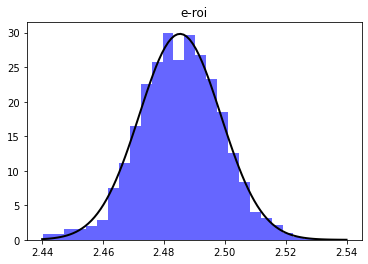

Fit results: mu = 2.485293199843235,  std = 0.013378694451507413 
Energy region between [2.418399727585698, 2.5521866721007718] MeV


In [38]:
tracks_selectron_zoom = tracks_selectron_ROIovlp1trackfid[(tracks_selectron_ROIovlp1trackfid.energy >= 2.44)]
energy_selectron_zoom = tracks_selectron_zoom.energy

mu, std = norm.fit(energy_selectron_zoom)

# Plot the histogram.
plt.hist(energy_selectron_zoom, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
x = np.linspace(2.44, emax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.title('e-roi')

plt.show()

print(f'Fit results: mu = {mu},  std = {std} ')
emin = mu-5*std
emax = mu+5*std
print(f'Energy region between [{emin}, {emax}] MeV')

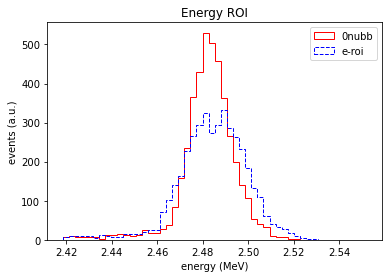

In [39]:
#Selecting events in the ROI
tracks_0nubb_ROI = tracks_0nubb[(tracks_0nubb.energy >= emin) & (tracks_0nubb.energy <= emax)]
tracks_0nubb_ROIovlp1trackfid = tracks_0nubb_ovlp1trackfid[(tracks_0nubb_ovlp1trackfid.energy >= emin) & (tracks_0nubb_ovlp1trackfid.energy <= emax)]

tracks_selectron_ROI = tracks_selectron[(tracks_selectron.energy >= emin) & (tracks_selectron.energy <= emax)]
tracks_selectron_ROIovlp1trackfid = tracks_selectron_ovlp1trackfid[(tracks_selectron_ovlp1trackfid.energy >= emin) & (tracks_selectron_ovlp1trackfid.energy <= emax)]


energy_0nubb = tracks_0nubb_ROIovlp1trackfid.energy
energy_selectron = tracks_selectron_ROIovlp1trackfid.energy

plt.hist(energy_0nubb, bins = 50, range = (emin, emax), color='red', histtype='step', label = '0nubb')
plt.hist(energy_selectron, bins = 50, range = (emin, emax), color='blue', histtype='step', label = 'e-roi', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Energy ROI')
plt.legend(loc=1);
plt.show()

In [40]:
#Checking total amount of events, after ROI selection
nevents_0nubb_ROI = tracks_0nubb_ROI.event.nunique()
Enevents_0nubb_ROI = np.sqrt(nevents_0nubb_ROI)
nevents_0nubb_ROIovlp1trackfid = tracks_0nubb_ROIovlp1trackfid.event.nunique()
Enevents_0nubb_ROIovlp1trackfid = np.sqrt(nevents_0nubb_ROIovlp1trackfid)

nevents_selectron_ROI = tracks_selectron_ROI.event.nunique()
Enevents_selectron_ROI = np.sqrt(nevents_selectron_ROI)
nevents_selectron_ROIovlp1trackfid = tracks_selectron_ROIovlp1trackfid.event.nunique()
Enevents_selectron_ROIovlp1trackfid = np.sqrt(nevents_selectron_ROIovlp1trackfid)


ratio_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_ovlp1trackfid
Eratio_ROIovlp1trackfid_0nubb = myef.ratio_error(ratio_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_ovlp1trackfid, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_ovlp1trackfid)

eff_ROIovlp1trackfid_0nubb = 100*nevents_0nubb_ROIovlp1trackfid/nevents_0nubb_total
Eeff_ROIovlp1trackfid_0nubb = myef.ratio_error(eff_ROIovlp1trackfid_0nubb, nevents_0nubb_ROIovlp1trackfid, nevents_0nubb_total, 
                                             Enevents_0nubb_ROIovlp1trackfid, Enevents_0nubb_total)

ratio_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_ovlp1trackfid
Eratio_ROIovlp1trackfid_selectron = myef.ratio_error(ratio_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_ovlp1trackfid, 
                                             Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_ovlp1trackfid)

eff_ROIovlp1trackfid_selectron = 100*nevents_selectron_ROIovlp1trackfid/nevents_selectron_total
Eeff_ROIovlp1trackfid_selectron = myef.ratio_error(eff_ROIovlp1trackfid_selectron, nevents_selectron_ROIovlp1trackfid, nevents_selectron_total,
                                                   Enevents_selectron_ROIovlp1trackfid, Enevents_selectron_total)
    
print('--------------------------0nubb-------------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_0nubb_total}        ')
print(f'FIDUCIAL   {nevents_0nubb_fiducial}                ---      {ratio_fiducial_0nubb} +- {Eratio_fiducial_0nubb}%')
print(f'1TRACK.    {nevents_0nubb_1trackfid}        {ratio_1trackfid_0nubb}+- {Eratio_1trackfid_0nubb}% {eff_1trackfid_0nubb} +- {Eeff_1trackfid_0nubb}%')
print(f'OVLP       {nevents_0nubb_ovlp1trackfid}        {ratio_ovlp1trackfid_0nubb}+- {Eratio_ovlp1trackfid_0nubb}%   {eff_ovlp1trackfid_0nubb} +- {Eeff_ovlp1trackfid_0nubb}%')
print(f'ROI        {nevents_0nubb_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_0nubb}+- {Eratio_ROIovlp1trackfid_0nubb}%   {eff_ROIovlp1trackfid_0nubb} +- {Eeff_ROIovlp1trackfid_0nubb}%')
print('--------!--------------!----------------!----------------')
print(' ')
print(' ')
print('--------------------------SElectron---------------------')
print('--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---')
print(f'INITIAL    {nevents_selectron_total}        ')
print(f'FIDUCIAL   {nevents_selectron_fiducial}                ---      {ratio_fiducial_selectron} +- {Eratio_fiducial_selectron}%')
print(f'1TRACK.    {nevents_selectron_1trackfid}        {ratio_1trackfid_selectron}+- {Eratio_1trackfid_selectron}% {eff_1trackfid_selectron} +- {Eeff_1trackfid_selectron}%')
print(f'OVLP       {nevents_selectron_ovlp1trackfid}        {ratio_ovlp1trackfid_selectron}+- {Eratio_ovlp1trackfid_selectron}%   {eff_ovlp1trackfid_selectron} +- {Eeff_ovlp1trackfid_selectron}%')
print(f'ROI        {nevents_selectron_ROIovlp1trackfid}        {ratio_ROIovlp1trackfid_selectron}+- {Eratio_ROIovlp1trackfid_selectron}%   {eff_ROIovlp1trackfid_selectron} +- {Eeff_ROIovlp1trackfid_selectron}%')
print('--------!--------------!----------------!----------------')

--------------------------0nubb-------------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9791        
FIDUCIAL   6417                ---      65.53978143192728 +- 1.0526649380958726%
1TRACK.    6417        100.0+- 1.7654238044412536% 65.53978143192728 +- 1.0526649380958726%
OVLP       5720        89.13822658563191+- 1.6208977948747234%   58.42099887651925 +- 0.9722486246586135%
ROI        4230        73.95104895104895+- 1.499642296280896%   43.20294147686651 +- 0.7949120903148927%
--------!--------------!----------------!----------------
 
 
--------------------------SElectron---------------------
--CUT---!----EVENTS----!---REDUCTION---!---EFFICIENCY---
INITIAL    9766        
FIDUCIAL   6175                ---      63.2295719844358 +- 1.0280190958814335%
1TRACK.    6175        100.0+- 1.7996850826633901% 63.2295719844358 +- 1.0280190958814335%
OVLP       5963        96.56680161943319+- 1.7532769705721076%   61.05877534302683 +- 1.0034780586956173%
R

## Blob Assignation

### SIGNAL EVENTS

In [41]:
reco_0nubb_e = []

reco_0nubb_e = myrvt.blobassignation_notrue(tracks_0nubb, tracks_0nubb_ROIovlp1trackfid)

In [42]:
len(reco_0nubb_e[0])

4140

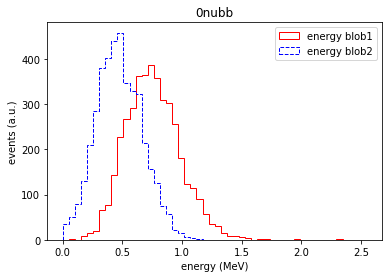

In [43]:
plt.hist(reco_0nubb_e[1], bins = 50, range = (0, 2.55), color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_0nubb_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

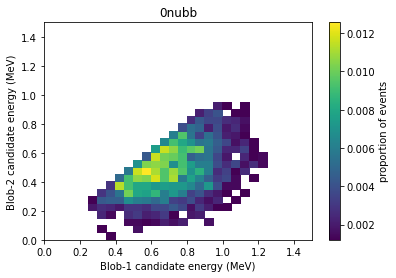

In [44]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], reco_0nubb_e[2], weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob-1 candidate energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

### BACKGROUND EVENTS

In [45]:
reco_selectron_e = []

reco_selectron_e = myrvt.blobassignation_notrue(tracks_selectron, tracks_selectron_ROIovlp1trackfid)

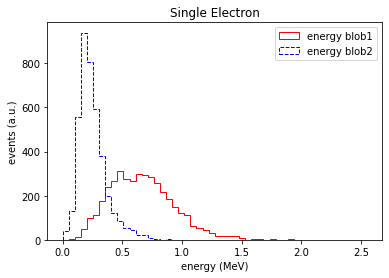

In [46]:
plt.hist(reco_selectron_e[1], bins = 50, range = (0, 2.55),color='red', histtype='step', label = 'energy blob1')
plt.hist(reco_selectron_e[2], bins = 50, range = (0, 2.55), color='blue', histtype='step', label = 'energy blob2', linestyle='dashed')

plt.xlabel('energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

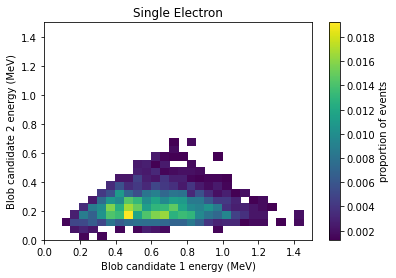

In [47]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], reco_selectron_e[2], weights=weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('Blob candidate 1 energy (MeV)')
plt.ylabel('Blob candidate 2 energy (MeV)')
plt.title('Single Electron')
plt.colorbar(label='proportion of events')

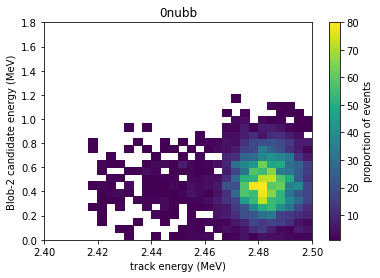

In [48]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[2], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-2 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

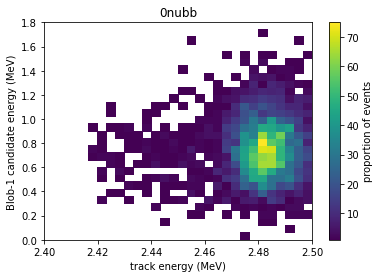

In [49]:
weights = myhf.get_weights(reco_0nubb_e[0], True)

plt.hist2d(reco_0nubb_e[0], reco_0nubb_e[1], bins=(30, 30), range=((2.4, 2.5), (0, 1.8)), cmap='viridis', cmin=0.001)
plt.xlabel('track energy (MeV)')
plt.ylabel('Blob-1 candidate energy (MeV)')
plt.title('0nubb')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

## Representing RECO vs TRUE

In [50]:
#0nubb hit files taken from FULLSIM simulations
hits_list_0nubb = []
filepath_0nubb_hits = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/'


filename_0nubb_hits = filepath_0nubb_hits+f'next100.0nubb.1.deconv.h5'
h5file = tb.open_file(filename_0nubb_hits)
h5file

File(filename=/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/next100.0nubb.1.deconv.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/DECO (Group) ''
/DECO/Events (Table(254988,), shuffle, zlib(4)) 'Deconvolved hits'
  description := {
  "event": Int64Col(shape=(), dflt=0, pos=0),
  "npeak": UInt64Col(shape=(), dflt=0, pos=1),
  "X": Float64Col(shape=(), dflt=0.0, pos=2),
  "Y": Float64Col(shape=(), dflt=0.0, pos=3),
  "Z": Float64Col(shape=(), dflt=0.0, pos=4),
  "E": Float64Col(shape=(), dflt=0.0, pos=5)}
  byteorder := 'little'
  chunkshape := (1365,)
  autoindex := True
  colindexes := {
    "event": Index(6, medium, shuffle, zlib(1)).is_csi=False}
/MC (Group) ''
/MC/configuration (Table(41,), shuffle, zlib(4)) ''
  description := {
  "param_key": StringCol(itemsize=300, shape=(), dflt=b'', pos=0),
  "param_value": StringCol(itemsize=300, sh

In [51]:
#0nubb files
true_list_0nubb = []
filepath_0nubb_true = filepath_0nubb_hits

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true = filepath_0nubb_true+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb = pd.read_hdf(filename_0nubb_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_0nubb_true))
        continue
        
    true_list_0nubb.append(readfile_true_0nubb)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb = pd.concat([dt for dt in true_list_0nubb]) 
true_0nubb.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [52]:
true_0nubb_primary = true_0nubb[true_0nubb.primary == True]
true_0nubb_primary_part1 = true_0nubb_primary[true_0nubb_primary.particle_id == 1]
true_0nubb_primary_part2 = true_0nubb_primary[true_0nubb_primary.particle_id == 2]
true_0nubb_event0 = true_0nubb[true_0nubb.event_id == 0]

In [53]:
diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b1_z_0nubb = [], [], []
diff_b2_x_0nubb, diff_b2_y_0nubb, diff_b2_z_0nubb = [], [], []

reco_0nubb_e = []

diff_b1_x_0nubb, diff_b1_y_0nubb, diff_b2_x_0nubb, diff_b2_y_0nubb, reco_0nubb_e = myrvt.blobassignation(true_0nubb, tracks_0nubb_ROIovlp1trackfid, 'signal')

Total events = 4142
Events 12 = 2095 (50.57943022694351%)
Events 21 = 2047 (49.42056977305649%)
Events NA = 0 (0.0%)


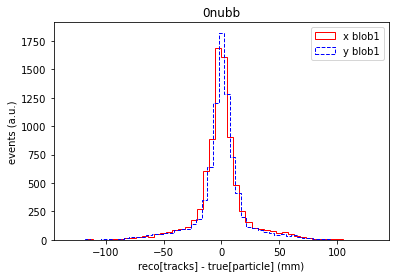

In [54]:
plt.hist(diff_b1_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

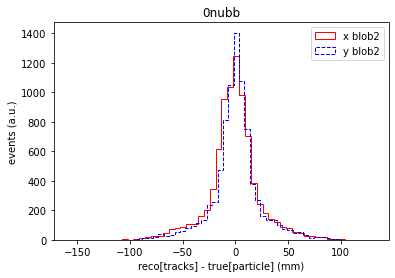

In [55]:
plt.hist(diff_b2_x_0nubb, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_0nubb, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.legend(loc=1);
plt.show()

In [56]:
#single electron files
true_list_selectron = []
filepath_selectron_true = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/e-_roi/hits/'

#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true = filepath_selectron_true+f'next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron = pd.read_hdf(filename_selectron_true, 'MC/particles')
    except:
        print('File {} not good'.format(filename_selectron_true))
        continue
        
    true_list_selectron.append(readfile_true_selectron)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron = pd.concat([dt for dt in true_list_selectron]) 
true_selectron.columns  

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [57]:
true_selectron_primary = true_selectron[true_selectron.primary == True]

true_selectron_primary_part1 = true_selectron_primary[true_selectron_primary.particle_id == 1]
true_selectron_primary_part2 = true_selectron_primary[true_selectron_primary.particle_id == 2]

In [58]:
diff_b1_x_selectron, diff_b1_y_selectron, diff_b1_z_selectron = [], [], []
diff_b2_x_selectron, diff_b2_y_selectron, diff_b2_z_selectron = [], [], []

reco_selectron_e = []

diff_b1_x_selectron, diff_b1_y_selectron, diff_b2_x_selectron, diff_b2_y_selectron, reco_selectron_e = myrvt.blobassignation(true_selectron, tracks_selectron_ROIovlp1trackfid, 'bkg')

Total events = 4008
Events 12 = 373 (9.306387225548903%)
Events 21 = 3635 (90.6936127744511%)
Events NA = 0 (0.0%)


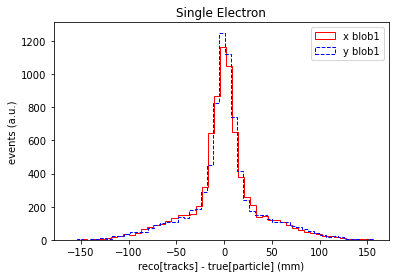

0.12432358726299081

In [59]:
plt.hist(diff_b1_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob1')
plt.hist(diff_b1_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob1', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()
(np.mean(diff_b1_x_selectron)+np.mean(diff_b1_y_selectron))/2

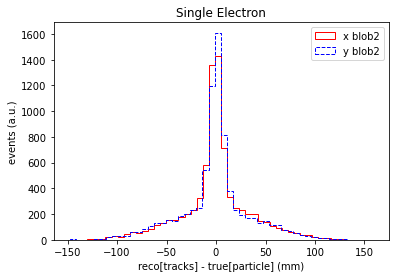

-0.5177280724857316

In [60]:
plt.hist(diff_b2_x_selectron, bins = 50, color='red', histtype='step', label = 'x blob2')
plt.hist(diff_b2_y_selectron, bins = 50, color='blue', histtype='step', label = 'y blob2', linestyle='dashed')

plt.xlabel('reco[tracks] - true[particle] (mm)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.legend(loc=1);
plt.show()

(np.mean(diff_b2_x_selectron)+np.mean(diff_b2_y_selectron))/2

## BLOB ENERGY = true vs reco

In [61]:
#0nubb files
true_list_0nubb_hits = []
filepath_0nubb_true_hits = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/0nubb/hits/'
#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_0nubb_true_hits = filepath_0nubb_true_hits+f'next100.0nubb.{nfile}.deconv.h5'

    try:
        readfile_true_0nubb_hits = pd.read_hdf(filename_0nubb_true_hits, 'MC/hits')
    except:
        print('File {} not good'.format(filename_0nubb_true_hits))
        continue
        
    true_list_0nubb_hits.append(readfile_true_0nubb_hits)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_0nubb_hits = pd.concat([dt for dt in true_list_0nubb_hits]) 
true_0nubb_hits.columns  

Index(['event_id', 'particle_id', 'hit_id', 'x', 'y', 'z', 'time', 'energy',
       'label'],
      dtype='object')

In [62]:
#0nubb files
true_list_selectron_hits = []
filepath_selectron_true_hits = '/Users/halmamol/NEXT/files/NEXT100/beershebaFS/e-_roi/hits/'
#loop over all the files, to read 'HITS' information
for nfile in range(1,max0nubbf):
    
    filename_selectron_true_hits = filepath_selectron_true_hits+f'next100.e-_roi.{nfile}.deconv.h5'

    try:
        readfile_true_selectron_hits = pd.read_hdf(filename_selectron_true_hits, 'MC/hits')
    except:
        print('File {} not good'.format(filename_selectron_true_hits))
        continue
        
    true_list_selectron_hits.append(readfile_true_selectron_hits)
    
#'concat' command means: 'concatenate pandas objects along a particular 
# axis with optional set logic along the other axes.' -> following line 
# is needed to keep an order between the files

true_selectron_hits = pd.concat([dt for dt in true_list_selectron_hits]) 
true_selectron_hits.columns  

Index(['event_id', 'particle_id', 'hit_id', 'x', 'y', 'z', 'time', 'energy',
       'label'],
      dtype='object')

In [63]:
b1_true_0nubb, b2_true_0nubb  = [], []
for j in range (0,len(reco_0nubb_e[3])):
    evt_number = reco_0nubb_e[3][j]

    #print(evt_number)
    
    evt_hits = true_0nubb_hits[true_0nubb_hits.event_id == evt_number]
    evt_hits = evt_hits[evt_hits.label == 'ACTIVE']

    xt = evt_hits.x
    yt = evt_hits.y
    zt = evt_hits.z
    et = evt_hits.energy
    
    true_0nubb_evt = true_0nubb[true_0nubb.event_id == evt_number]
    true_0nubb_evt_primary = true_0nubb_evt[true_0nubb_evt.primary == True]
    part1 = true_0nubb_evt_primary[true_0nubb_evt_primary.particle_id == 1]
    part2 = true_0nubb_evt_primary[true_0nubb_evt_primary.particle_id == 2]
    
    x_e1 = part1.final_x.values[0]
    y_e1 = part1.final_y.values[0]
    z_e1 = part1.final_z.values[0]
    x_e2 = part2.final_x.values[0]
    y_e2 = part2.final_y.values[0]
    z_e2 = part2.final_z.values[0]

    bx = np.array([x_e1, x_e2])
    by = np.array([y_e1, y_e2])
    bz = np.array([z_e1, z_e2])

    b1_true_i, b2_true_i = 0.0, 0.0
    for i in range(1,len(xt)):
        R1 = np.sqrt((bx[0]-xt.values[i])**2+(by[0]-yt.values[i])**2+(bz[0]-zt.values[i])**2)
        R2 = np.sqrt((bx[1]-xt.values[i])**2+(by[1]-yt.values[i])**2+(bz[1]-zt.values[i])**2)
        if R1<blobR:
            b1_true_i = b1_true_i + et.values[i]
        if R2<blobR:
            b2_true_i = b2_true_i + et.values[i]
    b1_true_0nubb.append(b1_true_i)
    b2_true_0nubb.append(b2_true_i)
    #print(b1_true_i)

In [64]:
len(b1_true_0nubb)

4142

In [65]:
len(reco_0nubb_e[1])

4142

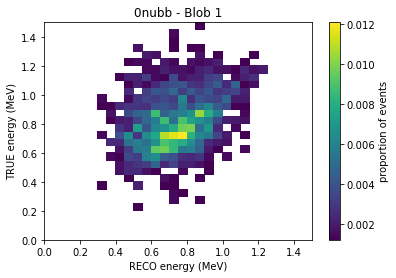

In [66]:
weights = myhf.get_weights(reco_0nubb_e[1], True)

plt.hist2d(reco_0nubb_e[1], b1_true_0nubb, weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('RECO energy (MeV)')
plt.ylabel('TRUE energy (MeV)')
plt.title('0nubb - Blob 1')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

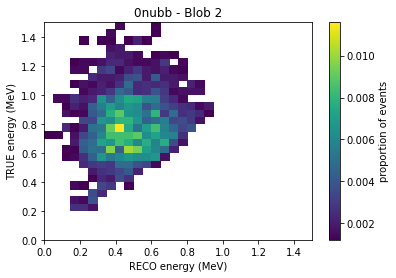

In [67]:
weights = myhf.get_weights(reco_0nubb_e[2], True)

plt.hist2d(reco_0nubb_e[2], b2_true_0nubb, weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('RECO energy (MeV)')
plt.ylabel('TRUE energy (MeV)')
plt.title('0nubb - Blob 2')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

In [68]:
b1_true_selectron = []
for j in range (0,len(reco_selectron_e[3])):
    evt_number = reco_selectron_e[3][j]

    #print(evt_number)
    
    evt_hits = true_selectron_hits[true_selectron_hits.event_id == evt_number]
    evt_hits = evt_hits[evt_hits.label == 'ACTIVE']

    xt = evt_hits.x
    yt = evt_hits.y
    zt = evt_hits.z
    et = evt_hits.energy
    
    true_selectron_evt = true_selectron[true_selectron.event_id == evt_number]
    true_selectron_evt_primary = true_selectron_evt[true_selectron_evt.primary == True]
    part1 = true_selectron_evt_primary[true_selectron_evt_primary.particle_id == 1]
    
    x_e1 = part1.final_x.values[0]
    y_e1 = part1.final_y.values[0]
    z_e1 = part1.final_z.values[0]

    bx = np.array([x_e1])
    by = np.array([y_e1])
    bz = np.array([z_e1])

    b1_true_i = 0.0
    for i in range(1,len(xt)):
        R1 = np.sqrt((bx[0]-xt.values[i])**2+(by[0]-yt.values[i])**2+(bz[0]-zt.values[i])**2)
        if R1<blobR:
            b1_true_i = b1_true_i + et.values[i]
    b1_true_selectron.append(b1_true_i)
    #print(b1_true_i)

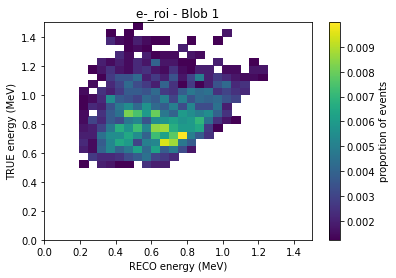

In [69]:
weights = myhf.get_weights(reco_selectron_e[1], True)

plt.hist2d(reco_selectron_e[1], b1_true_selectron, weights= weights, bins=(30, 30), range=((0, 1.5), (0, 1.5)), cmap='viridis', cmin=0.001)
plt.xlabel('RECO energy (MeV)')
plt.ylabel('TRUE energy (MeV)')
plt.title('e-_roi - Blob 1')
#plt.xlim((0.0,1.5))
plt.colorbar(label='proportion of events')

## Efficiency Values and FOM Estimation

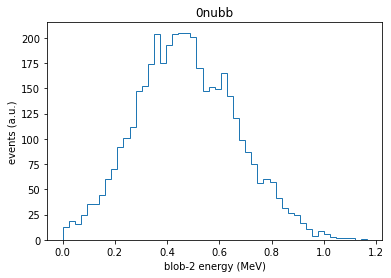

In [70]:
plt.hist(reco_0nubb_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('0nubb')
plt.show()

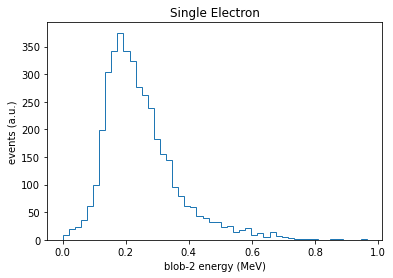

Total events 4008


In [71]:
plt.hist(reco_selectron_e[2], bins = 50, histtype='step', label = 'energy track')
plt.xlabel('blob-2 energy (MeV)')
plt.ylabel('events (a.u.)')
plt.title('Single Electron')
plt.show()

print(f'Total events {len(reco_selectron_e[0])}')

Since I need to compare both simulations, I'm going to use the same energy cuts. Besides, they seem reasonable looking into the blob2 energy distribution:

In [72]:
blobcut_energy=[]
#in MeV
minEcut = 0.010
maxEcut = 0.600
stepsEcut = 0.010

#defining the vector with the cut values
blobcut_energy=myef.blobthreshold(minEcut,maxEcut,stepsEcut)

Now I'm going to take the information from reco_selectron_e[][], to see how many events with each cut I get:

In [73]:
blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron = [], [] 

blobcut_energy_nevents_0nubb = myef.nevents_afterthreshold(blobcut_energy, reco_0nubb_e)
blobcut_energy_nevents_selectron = myef.nevents_afterthreshold(blobcut_energy, reco_selectron_e)

blobcut_energy_nevents_0nubb = np.array(blobcut_energy_nevents_0nubb, dtype=np.float)
blobcut_energy_nevents_selectron = np.array(blobcut_energy_nevents_selectron, dtype=np.float)

Create now arrays containing the statistical uncertainty (sqrt from total amount of events)

In [74]:
blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error= [], []

blobcut_energy_nevents_0nubb_error = myef.sqrterror_array(blobcut_energy_nevents_0nubb)
blobcut_energy_nevents_selectron_error = myef.sqrterror_array(blobcut_energy_nevents_selectron)

Text(0.5, 0, 'blob-2 energy threshold (MeV)')

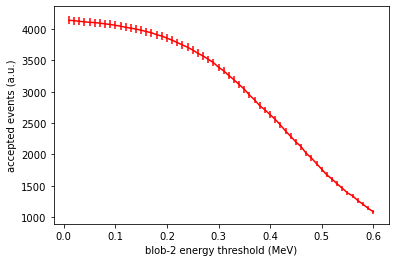

In [75]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,blobcut_energy_nevents_0nubb, yerr=blobcut_energy_nevents_0nubb_error, fmt = '-r')
plt.ylabel('accepted events (a.u.)')
plt.xlabel('blob-2 energy threshold (MeV)')
#plt.title('Cut efficiency')

Now that I have checked the accepted events for each energy cut, I'm going to compute the efficiency/background values:

In [76]:
fom_error, e_error, b_error = [], [], []

e, b, fom, e_error, b_error, fom_error = myef.efficiencyterms(blobcut_energy_nevents_0nubb, blobcut_energy_nevents_selectron, 
                            blobcut_energy_nevents_0nubb_error, blobcut_energy_nevents_selectron_error,
                            reco_0nubb_e, reco_selectron_e)

Text(0.5, 0, 'background rejection')

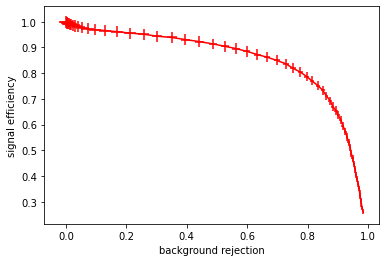

In [77]:
fig, ax = plt.subplots()
ax.errorbar(1-b,e, xerr=b_error, yerr=e_error, fmt = '-r')
plt.ylabel('signal efficiency')
plt.xlabel('background rejection')
#plt.title('Cut efficiency')

Text(0, 0.5, 'f.o.m.=e/sqrt(b)')

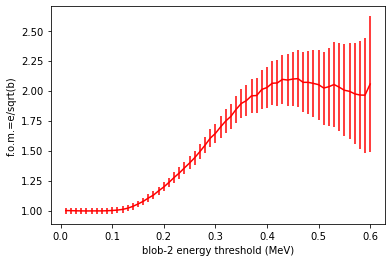

In [78]:
fig, ax = plt.subplots()
ax.errorbar(blobcut_energy,fom, yerr=fom_error,fmt = '-r')
plt.xlabel('blob-2 energy threshold (MeV)')
plt.ylabel('f.o.m.=e/sqrt(b)')
#plt.title('Cut efficiency')

In [79]:
myef.best_fom(e,b,fom,blobcut_energy)

Best fom is {2.0999517868498496}, that corresponds to:
- signal efficiency of 51.28%
- background acceptance of 5.96%
- energy threshold of 0.46 MeV


In [80]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ntracks_DETSIM_R{blobR}mm'
np.savez(npz_file, ntracks_0nubb=ntracks_0nubb, ntracks_eroi=ntracks_eroi)

In [81]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/recovstrue_DETSIM_R{blobR}mm'
np.savez(npz_file, diff_b1_x_0nubb=diff_b1_x_0nubb, diff_b1_y_0nubb=diff_b1_y_0nubb, diff_b1_z_0nubb=diff_b1_z_0nubb,
          diff_b2_x_0nubb=diff_b2_x_0nubb, diff_b2_y_0nubb=diff_b2_y_0nubb, diff_b2_z_0nubb=diff_b2_z_0nubb,
         diff_b1_x_selectron=diff_b1_x_selectron, diff_b1_y_selectron=diff_b1_y_selectron, diff_b1_z_selectron=diff_b1_z_selectron,
         diff_b2_x_selectron=diff_b2_x_selectron, diff_b2_y_selectron=diff_b2_y_selectron, diff_b2_z_selectron=diff_b2_z_selectron)


In [82]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/fom_DETSIM_R{blobR}mm'
np.savez(npz_file, e=e, b=b, fom=fom, e_error=e_error, b_error=b_error, fom_error=fom_error, blobcut_energy = blobcut_energy)

In [83]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/ereco_DETSIM_R{blobR}mm'
np.savez(npz_file, reco_0nubb_e=reco_0nubb_e, reco_selectron_e=reco_selectron_e)

In [84]:
npz_file = f'/Users/halmamol/NEXT/NBarrays/trackpos_DETSIM_R{blobR}mm'
np.savez(npz_file, track_0nubb_zmin=track_0nubb_zmin, track_0nubb_zmax=track_0nubb_zmax, track_0nubb_rmax = track_0nubb_rmax,
        track_selectron_zmin=track_selectron_zmin, track_selectron_zmax=track_selectron_zmin, track_selectron_rmax = track_selectron_rmax)


In [85]:
events_noaccept = []
for i in range(len(reco_0nubb_e[2])):
    if reco_0nubb_e[2][i] < 0.46:
        events_noaccept.append(reco_0nubb_e[3][i])
events_noaccept

[6.0,
 7.0,
 8.0,
 9.0,
 13.0,
 22.0,
 24.0,
 31.0,
 34.0,
 35.0,
 39.0,
 40.0,
 54.0,
 57.0,
 61.0,
 66.0,
 69.0,
 72.0,
 78.0,
 84.0,
 88.0,
 91.0,
 94.0,
 99.0,
 100.0,
 102.0,
 104.0,
 105.0,
 110.0,
 112.0,
 121.0,
 132.0,
 133.0,
 135.0,
 138.0,
 140.0,
 146.0,
 161.0,
 164.0,
 173.0,
 175.0,
 187.0,
 196.0,
 199.0,
 204.0,
 206.0,
 207.0,
 209.0,
 213.0,
 218.0,
 232.0,
 235.0,
 237.0,
 238.0,
 241.0,
 246.0,
 252.0,
 256.0,
 266.0,
 267.0,
 277.0,
 278.0,
 280.0,
 284.0,
 287.0,
 292.0,
 293.0,
 307.0,
 318.0,
 324.0,
 326.0,
 332.0,
 337.0,
 340.0,
 344.0,
 345.0,
 346.0,
 349.0,
 362.0,
 364.0,
 365.0,
 366.0,
 374.0,
 375.0,
 378.0,
 383.0,
 399.0,
 400.0,
 402.0,
 408.0,
 410.0,
 411.0,
 413.0,
 416.0,
 417.0,
 437.0,
 441.0,
 445.0,
 446.0,
 447.0,
 448.0,
 449.0,
 453.0,
 456.0,
 464.0,
 465.0,
 466.0,
 470.0,
 496.0,
 502.0,
 509.0,
 515.0,
 517.0,
 520.0,
 522.0,
 534.0,
 536.0,
 548.0,
 554.0,
 555.0,
 557.0,
 559.0,
 560.0,
 564.0,
 574.0,
 577.0,
 578.0,
 584.0,
 587

In [86]:
for i in range(len(reco_selectron_e[1])):
    print(f'Event {reco_selectron_e[3][i]}, Blob 1 energy {reco_selectron_e[1][i]} and Blob 2 energy {reco_selectron_e[2][i]}') 

Event 3.0, Blob 1 energy 1.0327744381269641 and Blob 2 energy 0.26298254569095236
Event 5.0, Blob 1 energy 0.5975884757252847 and Blob 2 energy 0.10458912233895508
Event 10.0, Blob 1 energy 0.8416779301610033 and Blob 2 energy 0.26409644316980646
Event 15.0, Blob 1 energy 0.2761236920046726 and Blob 2 energy 0.22294085371137148
Event 17.0, Blob 1 energy 1.6207721153069659 and Blob 2 energy 0.07228277560571042
Event 20.0, Blob 1 energy 0.20651246454815037 and Blob 2 energy 0.16377285201783207
Event 23.0, Blob 1 energy 0.8804334590164217 and Blob 2 energy 0.5474352771037094
Event 24.0, Blob 1 energy 0.5049899567945982 and Blob 2 energy 0.24048993042914646
Event 26.0, Blob 1 energy 0.5709234733256952 and Blob 2 energy 0.23297772244816686
Event 28.0, Blob 1 energy 0.4121531126285517 and Blob 2 energy 0.36948001677561404
Event 29.0, Blob 1 energy 0.6891575033918333 and Blob 2 energy 0.4448954364028849
Event 30.0, Blob 1 energy 0.6144760871653462 and Blob 2 energy 0.18341292997589193
Event 3

Event 3012.0, Blob 1 energy 1.0178554553193753 and Blob 2 energy 0.1539665935624216
Event 3014.0, Blob 1 energy 0.8689021682643832 and Blob 2 energy 0.2998107447101321
Event 3015.0, Blob 1 energy 0.5084278211993399 and Blob 2 energy 0.18303122047062897
Event 3019.0, Blob 1 energy 0.5576585395074242 and Blob 2 energy 0.14191869901789797
Event 3021.0, Blob 1 energy 0.641401562383496 and Blob 2 energy 0.09183550133974891
Event 3023.0, Blob 1 energy 0.5326823901268593 and Blob 2 energy 0.09088584562048801
Event 3024.0, Blob 1 energy 0.3670553244035503 and Blob 2 energy 0.12291233628249054
Event 3029.0, Blob 1 energy 0.8111971185944066 and Blob 2 energy 0.23455590877338067
Event 3030.0, Blob 1 energy 0.9437330096660663 and Blob 2 energy 0.526543988862154
Event 3032.0, Blob 1 energy 0.6795152381502648 and Blob 2 energy 0.1501191280060293
Event 3036.0, Blob 1 energy 0.6694967343911218 and Blob 2 energy 0.31719738278471116
Event 3039.0, Blob 1 energy 0.3299159405958329 and Blob 2 energy 0.2443

Event 5815.0, Blob 1 energy 0.8353745608180917 and Blob 2 energy 0.13056974656199136
Event 5823.0, Blob 1 energy 1.1149644195516155 and Blob 2 energy 0.30260231250640146
Event 5824.0, Blob 1 energy 0.7253410586048556 and Blob 2 energy 0.44508481451371296
Event 5828.0, Blob 1 energy 0.8013585836337952 and Blob 2 energy 0.18295682409514086
Event 5831.0, Blob 1 energy 1.0292430170352815 and Blob 2 energy 0.10920381757357571
Event 5833.0, Blob 1 energy 0.4809774435218955 and Blob 2 energy 0.26849181591915805
Event 5834.0, Blob 1 energy 0.35020569278610325 and Blob 2 energy 0.2000100440052185
Event 5837.0, Blob 1 energy 0.6853493683118199 and Blob 2 energy 0.5008391114623152
Event 5843.0, Blob 1 energy 1.1963792912920155 and Blob 2 energy 0.2593397560919214
Event 5845.0, Blob 1 energy 0.56168730243205 and Blob 2 energy 0.3361235679039628
Event 5846.0, Blob 1 energy 0.8351525288684205 and Blob 2 energy 0.26292130503654376
Event 5847.0, Blob 1 energy 0.11221051604016723 and Blob 2 energy 0.08

Event 9154.0, Blob 1 energy 0.7572491473827457 and Blob 2 energy 0.1737233342021466
Event 9156.0, Blob 1 energy 1.2092189780403046 and Blob 2 energy 0.7417370237506364
Event 9157.0, Blob 1 energy 0.26536792267051695 and Blob 2 energy 0.11370459581560054
Event 9158.0, Blob 1 energy 0.8620630713593448 and Blob 2 energy 0.12105041174657569
Event 9160.0, Blob 1 energy 0.8573270682041154 and Blob 2 energy 0.21206489418201815
Event 9162.0, Blob 1 energy 0.7204971094070539 and Blob 2 energy 0.26026653451455495
Event 9164.0, Blob 1 energy 0.19888570447716905 and Blob 2 energy 0.16911322252677655
Event 9166.0, Blob 1 energy 0.38381422671313065 and Blob 2 energy 0.35671740780577077
Event 9170.0, Blob 1 energy 0.2517433729802117 and Blob 2 energy 0.17575740775386497
Event 9175.0, Blob 1 energy 0.9141266127377646 and Blob 2 energy 0.2814731830658068
Event 9177.0, Blob 1 energy 0.6684921725947999 and Blob 2 energy 0.17974095833269219
Event 9179.0, Blob 1 energy 0.7947551737028629 and Blob 2 energy 